In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import tensorflow as tf
import collections
from PIL import Image
from IPython.display import display

In [2]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

n=100

# Loaded a set of images
root_dir = "../training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


### Load images, preprocess
- load images 400x400
- slice them by 100x100 (16x more images)
- preprocess for cnn :
- - put mean to 0
- - normalize with norm2
- - flatten shape

train labels shape=  (1600, 10000)
train labels min=  0.0
train labels max=  0.998925207061
train data shape=  (1600, 10000, 3)
train data min=  0.0
train data max=  1.0


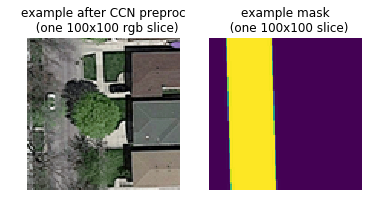

In [3]:
def preprocess_image_for_cnn(img):
    img = img.copy()
    d = img.shape[2]
    output_img = np.zeros([img.shape[0]*img.shape[1],d])
    for i in range(d):
        img[:,:,i] -= np.min(img[:,:,i])
        img[:,:,i] /= np.max(img[:,:,i])
        #img[:,:,i] -= np.mean(img[:,:,i])
        
        #img[:,:,i] /= np.linalg.norm(img[:,:,i])
        output_img[:,i] = img[:,:,i].reshape(img.shape[0]*img.shape[1]);
    
    return output_img

# returns 16 100x100 rgb images from one 400x400 rgb image
def slice_image_by_16_pieces(img):
    img = img.copy()
    results = np.zeros([16, 100,100,3])
    for i in range(4):
        for j in range(4):
            results[j+4*i,:,:,:] = img[i*100:(i+1)*100,j*100:(j+1)*100,:]
        
    return results

# returns 16 100x100  images from one 400x400 image
def slice_mask_by_16_pieces(img):
    results = np.zeros([16, 100,100])
    for i in range(4):
        for j in range(4):
            results[j+4*i,:,:] = img[i*100:(i+1)*100,j*100:(j+1)*100]
        
    return results
        

# TRAIN DATA PREPARATION

n=100

# create 1600 baches of data 100x100 from 100 baches 400x400
train_data = np.zeros([1600,10000,3])
for i in range(n):
    temp = slice_image_by_16_pieces(imgs[i])
    for j in range(16):
        img = preprocess_image_for_cnn(temp[j,:,:,:])
        img -= np.min(img)
        img = img / np.max(img)
        #img -= np.mean(img)
        train_data[16*i + j,:,:] = img
    

# TEST labels PREPARATION
train_labels = np.zeros([1600,10000])
for i in range(n):
    temp = slice_mask_by_16_pieces(gt_imgs[i])
    for j in range(16):
        img =  temp[j].reshape([10000]) 
        train_labels[16*i+j,:] =img / np.max(img+0.001)

print('train labels shape= ', train_labels.shape)
print('train labels min= ', np.min(train_labels))
print('train labels max= ', np.max(train_labels))

print('train data shape= ', train_data.shape)
print('train data min= ', train_data.min())
print('train data max= ', train_data.max())

n = 1600 # nr of data 

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.subplot(121);
img_preprocessed = train_data[3].reshape([100,100,3])
img_preprocessed -= np.min(img_preprocessed);
img_preprocessed /= np.max(img_preprocessed);
plt.imshow(img_preprocessed);
plt.title('example after CCN preproc\n  (one 100x100 rgb slice)');
plt.axis('off')
plt.subplot(122);
plt.imshow(train_labels[3].reshape([100,100]));
plt.title('example mask\n  (one 100x100 slice)');
plt.axis('off');
plt.show()

# Model 1 
In the first model it has been implemented a baseline softmax classifier using a single convolutional layer and a one fully connected layer. For the initial baseline
it has not be used any regularization, dropout, or batch normalization.

The equation of the classifier is:


$$
x= ReLU( \textrm{max_3colors}(x_{100x100,3} \ast W_0+b_0)_{100x100})
$$
$$
x=ReLU( x_{100x100}) \ast W_1+b_1)+b_{fc}
$$
$$
y = \textrm{softmax}(x)+0.5
$$
For this first attempt have been applied 64 filters with size 10x10.  

In [4]:
def conv2d(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 1, 1, 1], padding='SAME')
    
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[ 1, 2, 2, 1], strides=[ 1, 2, 2, 1], padding='SAME')


def weight_variable(shape, d):
        initial = tf.random_normal(shape, stddev=tf.sqrt(2./tf.to_float(d)) )
        #initial = tf.constant(0.01,shape=shape)
        return tf.Variable(initial)
    
def bias_variable(shape, d):
    initial = tf.random_normal(shape, stddev=tf.sqrt(2./tf.to_float(ncl0)) )
    return tf.Variable(initial)

def calc_f1_score(y, y_truth):

    tp = np.sum(np.sum((y_truth[y>np.mean(y)] >0)))
    tn = np.sum(np.sum((y_truth[y<np.mean(y)] < 0)))
    fp = np.sum(np.sum((y_truth[y<np.mean(y)] > 0)))
    fn = np.sum(np.sum((y_truth[y>np.mean(y)] < 0)))

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return f1_score

In [6]:
# CNN for 3 colors - building computational graph

tf.reset_default_graph()

pix_w = 100      # image width in pix
d = pix_w*pix_w  # data dimensionality
nr_cols = 3      # number of colors 
batch_size = 200      # batch size

#Size and number of filters - conv layer 1
K0 = 3   # size of the patch in the filter
F0 = 32  # number of filters per color
ncl0 = K0*K0*F0

# Inputs
xin_3cols = tf.placeholder(tf.float32,[batch_size,d, nr_cols]);  
y_truth = tf.placeholder(tf.float32,[batch_size,d]);
learn_rate = tf.placeholder(tf.float32);

########## 1st Convolutional layer (for 3 colors)
Wcl0 = weight_variable([nr_cols,K0,K0,1,F0], ncl0); print('Wcl0=',Wcl0.get_shape())
bcl0 = bias_variable([nr_cols,F0], ncl0); print('bcl0=',bcl0.get_shape()) 

#Convolution for 3 colors : Reshaping the input to size 100x100
x_2d0_r = tf.reshape(xin_3cols[:,:,0], [-1,pix_w,pix_w,1]); print('x_2d_r=',x_2d0_r.get_shape())
x_2d0_g = tf.reshape(xin_3cols[:,:,1], [-1,pix_w,pix_w,1]); print('x_2d_g=',x_2d0_g.get_shape())
x_2d0_b = tf.reshape(xin_3cols[:,:,2], [-1,pix_w,pix_w,1]); print('x_2d_b=',x_2d0_b.get_shape())
    
x_r = tf.nn.conv2d(x_2d0_r, Wcl0[0], strides=[1, 1, 1, 1], padding='SAME')
x_r += bcl0[0]; print('x_r=',x_r.get_shape())

x_g = tf.nn.conv2d(x_2d0_g, Wcl0[1], strides=[1, 1, 1, 1], padding='SAME')
x_g += bcl0[1]; print('x_g=',x_g.get_shape())

x_b = tf.nn.conv2d(x_2d0_b, Wcl0[2], strides=[1, 1, 1, 1], padding='SAME')
x_b += bcl0[2]; print('x_b=',x_b.get_shape())

x = tf.pack([x_r, x_g, x_b])

#choosing the max kernel from 3 colors
x = tf.reduce_max(x, reduction_indices=[0])

# max pooling layer
x = max_pool_2x2(x)

print('x_0=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)



#Size and number of filters - conv layer 2
K1 = 10   # size of the patch in the filter
F1 = 3  # number of filters
ncl1 = K1*K1*F1

########## 2nd Convolution layer (ony 1 color img now)

Wcl1 = weight_variable([K1,K1,1,F1], ncl1); print('Wcl2=',Wcl1.get_shape())
bcl1 = bias_variable([F1], ncl1); print('bcl2=',bcl1.get_shape()) 

x = tf.expand_dims(x, -1); print('x2_extend_dims=',x.get_shape()) 
x = tf.nn.conv2d(x, Wcl1, strides=[1, 1, 1, 1], padding='SAME')
x += bcl1; print('x2_lastconv=',x.get_shape())

# max pooling layer
x = max_pool_2x2(x); print('x3_maxpool=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

########## Fully Connected layer
#nfc = int(pix_w*pix_w*F1/16)
#x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
#Wfc = weight_variable([nfc,d], pix_w); print('Wfc=',Wfc.get_shape()) 
bfc = bias_variable([d],d); print('bfc=',bfc.get_shape())
#y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
#y += bfc; print('y2=',y.get_shape())

# Softmax 
#y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())
print('y_truth',y_truth.get_shape())

y_truth_maxpooled = tf.reshape(y_truth,[batch_size,100,100,1]); print('y_truth reshape',y_truth_maxpooled.get_shape())
y_truth_maxpooled = tf.nn.max_pool(y_truth_maxpooled, ksize=[ 1, 4, 4,1], strides=[ 1, 4, 4,1], padding='SAME'); print('y_truth maxpool',y_truth_maxpooled.get_shape())
y_truth_maxpooled = tf.reshape(y_truth_maxpooled, [batch_size, -1]); print('y_truth squeeze',y_truth_maxpooled.get_shape())

y = tf.nn.softmax(tf.reduce_sum(x,3)); 
y = tf.reshape(y, [batch_size, -1]); print('y(SOFTMAX)=',y.get_shape())

total_loss = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(y, y_truth_maxpooled, name='loss'))) 

# Optimization scheme
train_step = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(total_loss)

# Accuracy

accuracy = 1-(tf.reduce_mean(tf.reduce_mean(tf.abs(y - y_truth_maxpooled))))




Wcl0= (3, 5, 5, 1, 4)
bcl0= (3, 4)
x_2d_r= (200, 100, 100, 1)
x_2d_g= (200, 100, 100, 1)
x_2d_b= (200, 100, 100, 1)
x_r= (200, 100, 100, 4)
x_g= (200, 100, 100, 4)
x_b= (200, 100, 100, 4)
x_0= (200, 50, 50, 4)
Wcl2= (10, 10, 1, 3)
bcl2= (3,)
x2_extend_dims= (200, 50, 50, 4, 1)


ValueError: Shape must be rank 4 but is rank 5 for 'Conv2D_3' (op: 'Conv2D') with input shapes: [200,50,50,4,1], [10,10,1,3].

Initializing computational Graph
Finished computational Graph. Starting training.

Iteration i= 0 learning rate 0.06 , train accuracy= 0.751579 , f1= 0.560077686664 , loss= 25995.4
0.0222997
0.0832062
0.0117619
0.0939847
0.0173139
0.151991
0.021668
0.0699344
0.0186001
0.0956913


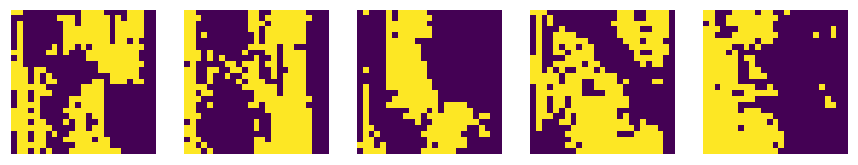

None


Iteration i= 100 learning rate 0.0594059405940594 , train accuracy= 0.731274 , f1= 0.5812058875 , loss= 28489.8
0.012083
0.0837831
0.0225087
0.170432
0.0238291
0.086806
0.0149938
0.0826196
0.0171558
0.0854527


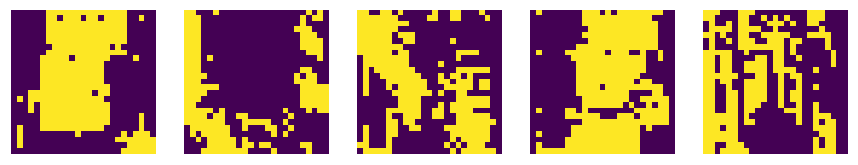

None


Iteration i= 200 learning rate 0.05881188118811881 , train accuracy= 0.751733 , f1= 0.568739205527 , loss= 25975.6
0.0174693
0.11592
0.0226976
0.0793171
0.0208045
0.0755839
0.0219725
0.0710603
0.0101324
0.0945256


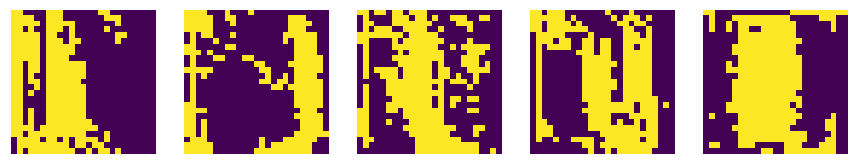

None


Iteration i= 300 learning rate 0.058217821782178214 , train accuracy= 0.758759 , f1= 0.558780874183 , loss= 25105.8
0.0130837
0.122141
0.0139198
0.127107
0.023538
0.0974536
0.024482
0.0902209
0.0199629
0.097948


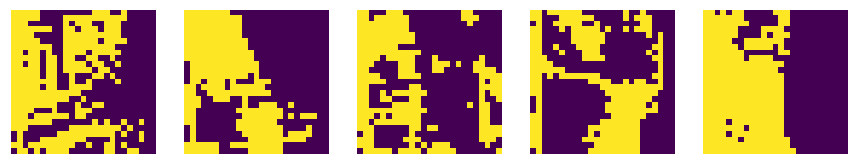

None


Iteration i= 400 learning rate 0.05762376237623762 , train accuracy= 0.75941 , f1= 0.574435889448 , loss= 25042.7
0.0214529
0.081084
0.0155709
0.101876
0.00753986
0.111893
0.0191132
0.112604
0.0200478
0.0760568


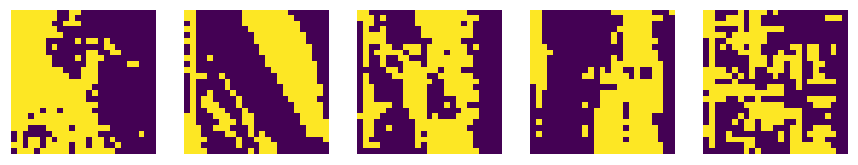

None


Iteration i= 500 learning rate 0.057029702970297025 , train accuracy= 0.751089 , f1= 0.588409600813 , loss= 26071.3
0.019157
0.0684452
0.0133716
0.148202
0.0240413
0.0895988
0.0216055
0.102847
0.017423
0.108385


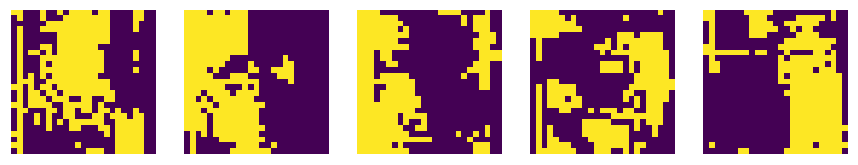

None


Iteration i= 600 learning rate 0.05643564356435643 , train accuracy= 0.767448 , f1= 0.564490740741 , loss= 24024.3
0.0194368
0.0806875
0.0233694
0.107679
0.0207089
0.0713283
0.0161241
0.230136
0.0213723
0.10513


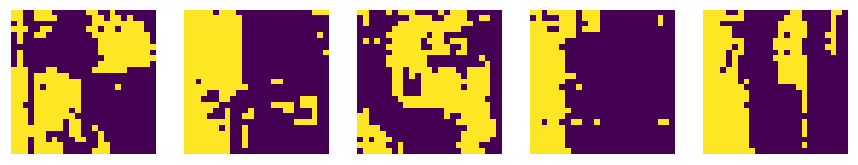

None


Iteration i= 700 learning rate 0.055841584158415836 , train accuracy= 0.731306 , f1= 0.555176880917 , loss= 28523.9
0.023015
0.0882337
0.020733
0.0610672
0.024537
0.0720574
0.0176819
0.0770294
0.0130837
0.122141


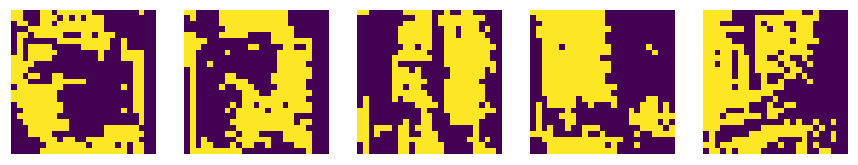

None


Iteration i= 800 learning rate 0.05524752475247525 , train accuracy= 0.761109 , f1= 0.559364964494 , loss= 24808.7
0.0165671
0.145033
0.022861
0.0653062
0.0212878
0.0970176
0.0196381
0.151487
0.0180485
0.144423


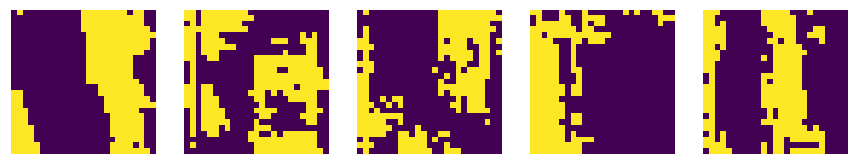

None


Iteration i= 900 learning rate 0.05465346534653465 , train accuracy= 0.758588 , f1= 0.586188879697 , loss= 25139.6
0.0226239
0.086997
0.0253305
0.0989073
0.0153157
0.235611
0.0162145
0.106384
0.0264996
0.0715617


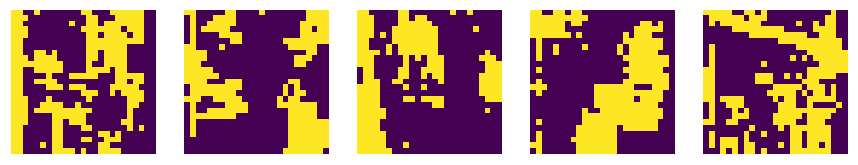

None


Iteration i= 1000 learning rate 0.05405940594059406 , train accuracy= 0.759854 , f1= 0.586002111561 , loss= 25002.6
0.0222689
0.100417
0.0245241
0.0659135
0.0273223
0.0753851
0.020147
0.100155
0.0246379
0.0753188


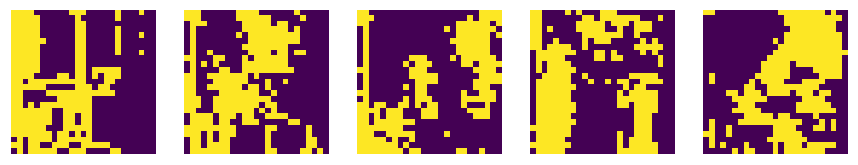

None


Iteration i= 1100 learning rate 0.053465346534653464 , train accuracy= 0.7691 , f1= 0.553720780613 , loss= 23837.6
0.0227252
0.0703213
0.019638
0.0980956
0.0193427
0.100503
0.0203773
0.102497
0.0139045
0.127187


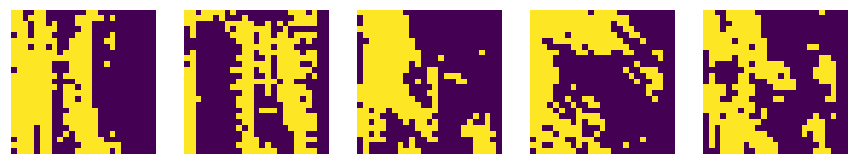

None


Iteration i= 1200 learning rate 0.05287128712871287 , train accuracy= 0.771658 , f1= 0.563787957743 , loss= 23502.8
0.0165617
0.14281
0.0233142
0.0669719
0.0224006
0.0987836
0.0146726
0.134641
0.0222765
0.112512


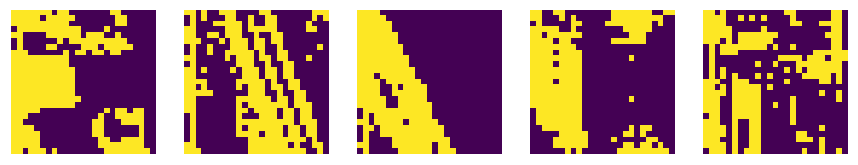

None


Iteration i= 1300 learning rate 0.052277227722772275 , train accuracy= 0.75272 , f1= 0.56586793648 , loss= 25864.5
0.0130482
0.199074
0.0207096
0.116934
0.0237543
0.080267
0.0232338
0.0714242
0.0226309
0.0861263


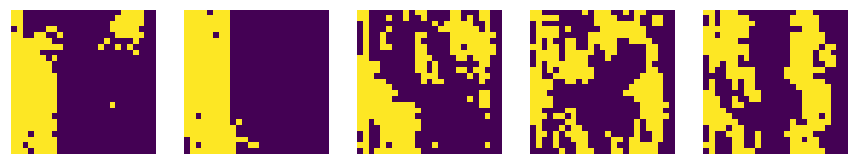

None


Iteration i= 1400 learning rate 0.05168316831683168 , train accuracy= 0.758927 , f1= 0.560016193239 , loss= 25107.0
0.0219714
0.0866482
0.0184511
0.112913
0.0257701
0.0647584
0.0214797
0.113521
0.0178443
0.0824482


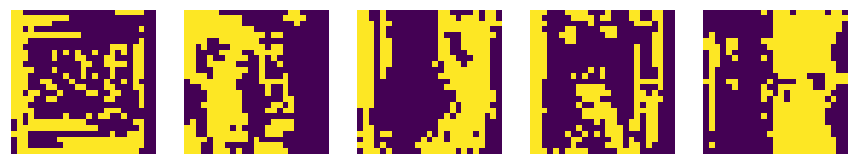

None


Iteration i= 1500 learning rate 0.051089108910891086 , train accuracy= 0.748419 , f1= 0.561814566988 , loss= 26411.5
0.0170155
0.079409
0.0242247
0.0728053
0.0139068
0.124926
0.0235621
0.0687104
0.0252513
0.0822184


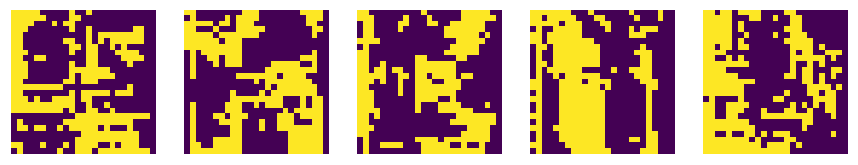

None


Iteration i= 1600 learning rate 0.05049504950495049 , train accuracy= 0.752259 , f1= 0.574904549278 , loss= 25907.0
0.022686
0.078555
0.0149233
0.105962
0.0218129
0.0744017
0.020924
0.128148
0.0216453
0.0775812


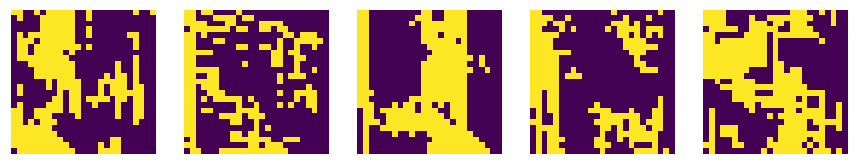

None


Iteration i= 1700 learning rate 0.0499009900990099 , train accuracy= 0.763947 , f1= 0.572477396841 , loss= 24447.2
0.0111376
0.0985466
0.019069
0.0730944
0.0266172
0.105208
0.0216106
0.0787965
0.0191355
0.0730295


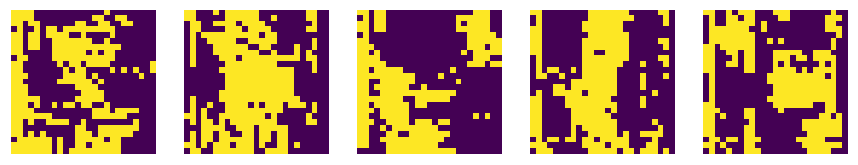

None


Iteration i= 1800 learning rate 0.04930693069306931 , train accuracy= 0.764944 , f1= 0.586214648622 , loss= 24348.0
0.0208968
0.0858655
0.0170753
0.125096
0.0172226
0.103039
0.0227472
0.0760059
0.0254397
0.0632642


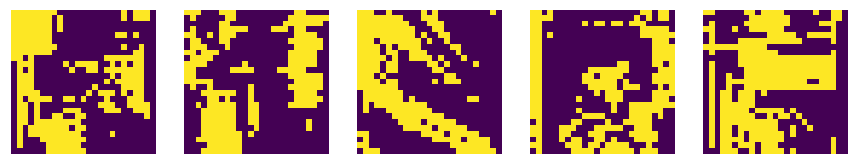

None


Iteration i= 1900 learning rate 0.048712871287128715 , train accuracy= 0.761631 , f1= 0.561458617864 , loss= 24732.3
0.0219621
0.0825405
0.01402
0.0897245
0.0142975
0.116028
0.0232601
0.0911528
0.0228629
0.122346


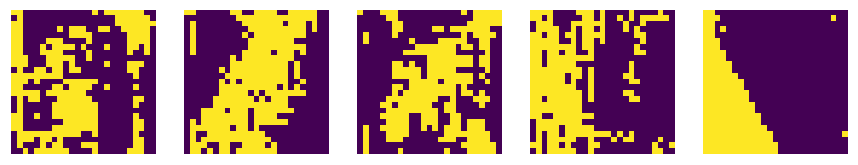

None


Iteration i= 2000 learning rate 0.04811881188118812 , train accuracy= 0.73756 , f1= 0.553870645142 , loss= 27737.6
0.0199543
0.152971
0.0164087
0.100475
0.0156296
0.187074
0.0205501
0.0917264
0.0250411
0.0691413


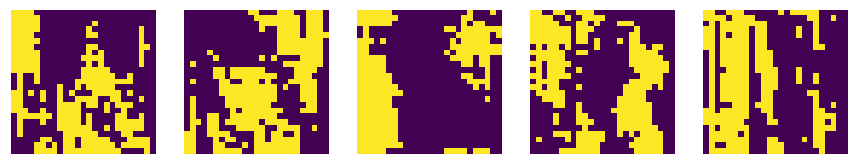

None


Iteration i= 2100 learning rate 0.047524752475247525 , train accuracy= 0.752847 , f1= 0.564986909579 , loss= 25829.2
0.0223328
0.124092
0.0150199
0.097687
0.0275153
0.0727355
0.0202095
0.0795446
0.0117619
0.0939847


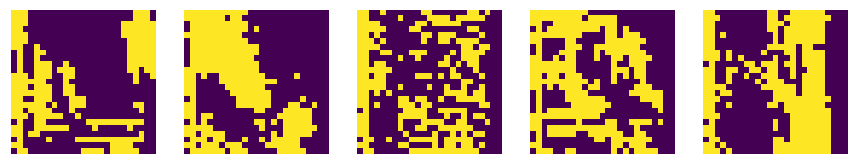

None


Iteration i= 2200 learning rate 0.04693069306930693 , train accuracy= 0.746856 , f1= 0.550186973148 , loss= 26591.3
0.021165
0.0771406
0.0198009
0.0765634
0.0142975
0.116028
0.0260361
0.0746477
0.0195047
0.110165


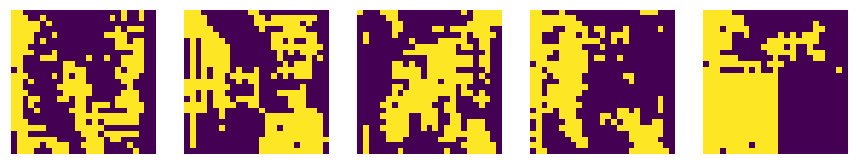

None


Iteration i= 2300 learning rate 0.046336633663366336 , train accuracy= 0.757399 , f1= 0.578978609273 , loss= 25290.6
0.0299586
0.0683621
0.020222
0.0724774
0.0224937
0.0738007
0.0314838
0.0629052
0.0159809
0.098942


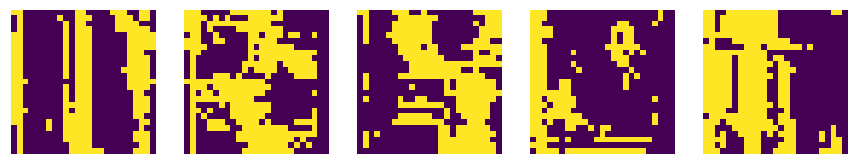

None


Iteration i= 2400 learning rate 0.04574257425742574 , train accuracy= 0.751046 , f1= 0.558158669669 , loss= 26050.9
0.0176912
0.0685634
0.0219118
0.0750485
0.015765
0.0875325
0.0256146
0.0927963
0.0244045
0.0775412


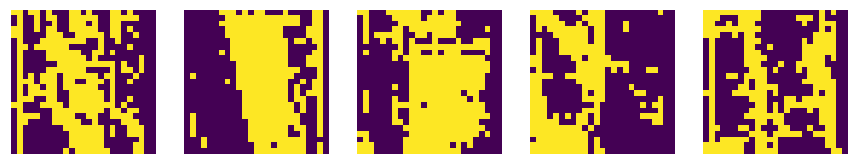

None


Iteration i= 2500 learning rate 0.04514851485148515 , train accuracy= 0.745972 , f1= 0.554737044392 , loss= 26729.4
0.0219071
0.0894171
0.0201969
0.115012
0.0161059
0.0907101
0.0242338
0.0748884
0.0151478
0.101476


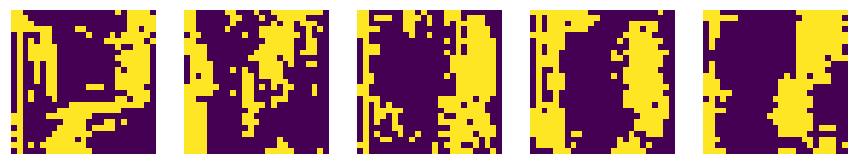

None


Iteration i= 2600 learning rate 0.04455445544554455 , train accuracy= 0.730364 , f1= 0.572518628912 , loss= 28656.2
0.0274356
0.0783707
0.023423
0.0918148
0.0197481
0.0699713
0.0188804
0.157581
0.0128252
0.0796141


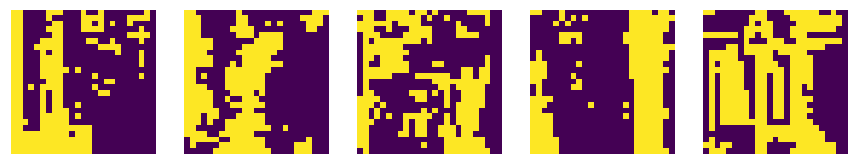

None


Iteration i= 2700 learning rate 0.04396039603960396 , train accuracy= 0.762329 , f1= 0.58093488467 , loss= 24683.3
0.0190549
0.108395
0.0221391
0.115225
0.0202012
0.0834718
0.0131997
0.14962
0.0163572
0.105775


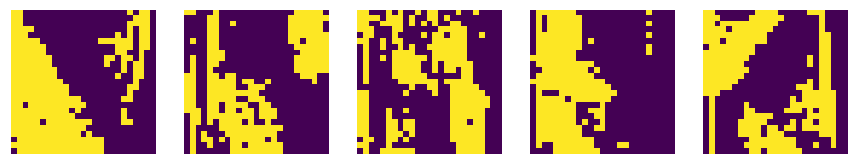

None


Iteration i= 2800 learning rate 0.04336633663366336 , train accuracy= 0.762656 , f1= 0.560203018081 , loss= 24616.8
0.0256156
0.0762541
0.0264849
0.0683114
0.0170058
0.119058
0.027743
0.080568
0.0240176
0.0828056


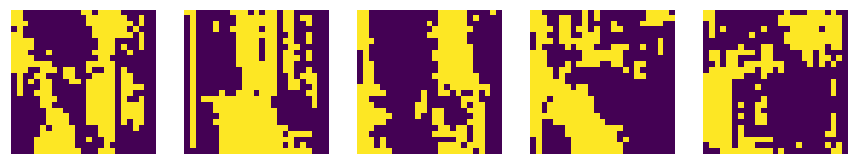

None


Iteration i= 2900 learning rate 0.04277227722772277 , train accuracy= 0.736201 , f1= 0.572501248128 , loss= 27925.8
0.0238775
0.0703375
0.0139045
0.127187
0.0230077
0.0722378
0.0148509
0.0870682
0.0214928
0.0777303


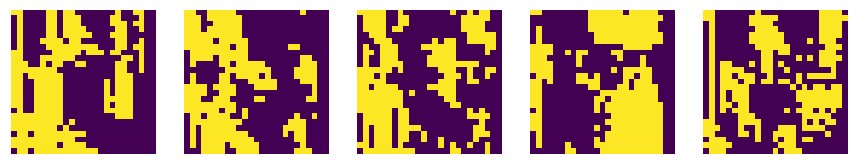

None


Iteration i= 3000 learning rate 0.042178217821782174 , train accuracy= 0.759307 , f1= 0.57371730326 , loss= 25040.4
0.0161571
0.0827706
0.0226622
0.0795324
0.0218354
0.0727708
0.0151952
0.195479
0.0148557
0.142771


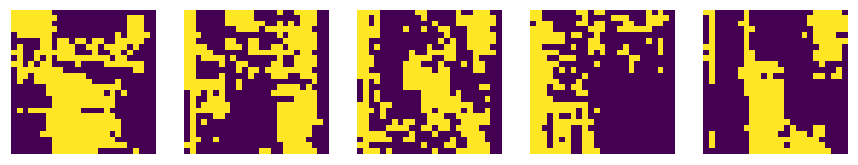

None


Iteration i= 3100 learning rate 0.04158415841584158 , train accuracy= 0.761499 , f1= 0.564883426712 , loss= 24789.5
0.019098
0.0979121
0.0252513
0.0822184
0.0149818
0.110161
0.024832
0.0982499
0.0157868
0.0833964


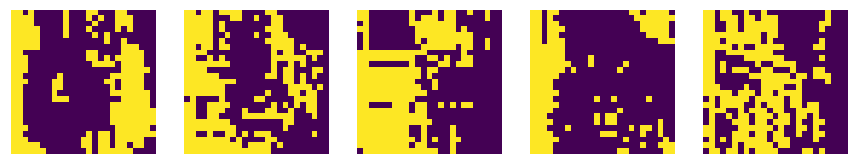

None


Iteration i= 3200 learning rate 0.040990099009900985 , train accuracy= 0.752397 , f1= 0.57829200628 , loss= 25880.0
0.0141781
0.0875948
0.0204164
0.1227
0.0182916
0.107894
0.0128742
0.117301
0.0248199
0.0701419


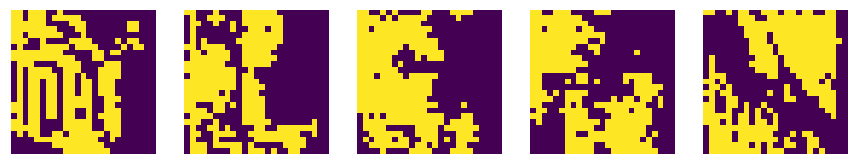

None


Iteration i= 3300 learning rate 0.04039603960396039 , train accuracy= 0.740861 , f1= 0.562741233473 , loss= 27315.0
0.0239839
0.0740327
0.0245583
0.0806536
0.0235861
0.122533
0.0211925
0.0851382
0.0207477
0.0826431


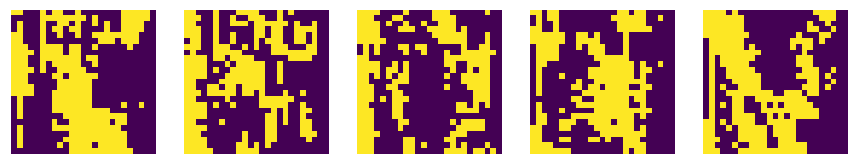

None


Iteration i= 3400 learning rate 0.039801980198019796 , train accuracy= 0.758652 , f1= 0.578330925658 , loss= 25109.5
0.0226812
0.0932419
0.0251099
0.0828704
0.0205233
0.0911817
0.0217935
0.101966
0.0211162
0.088077


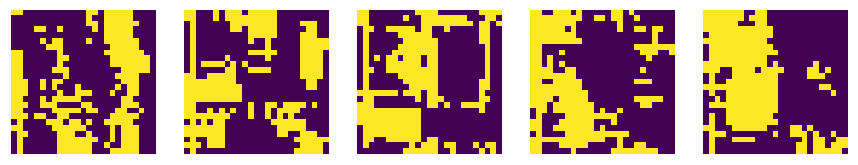

None


Iteration i= 3500 learning rate 0.03920792079207921 , train accuracy= 0.759546 , f1= 0.563004009551 , loss= 25049.9
0.0147364
0.0857115
0.0230397
0.0700236
0.0204975
0.112861
0.0224615
0.0771326
0.0144975
0.0771705


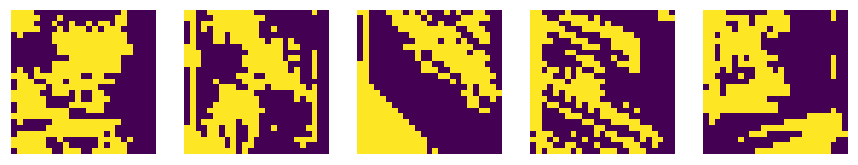

None


Iteration i= 3600 learning rate 0.03861386138613861 , train accuracy= 0.739299 , f1= 0.579171975811 , loss= 27543.2
0.0204522
0.106689
0.0158894
0.184505
0.0241118
0.0624899
0.0312658
0.0561516
0.0222351
0.0687103


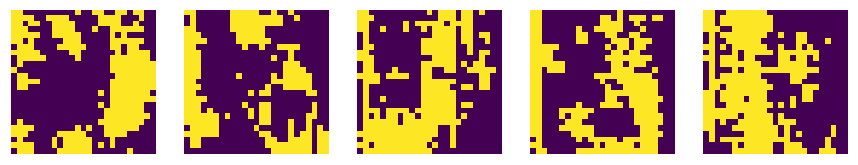

None


Iteration i= 3700 learning rate 0.03801980198019802 , train accuracy= 0.75014 , f1= 0.582682181077 , loss= 26186.9
0.0212595
0.104175
0.0218354
0.0727708
0.0120583
0.256947
0.0286317
0.0749337
0.0187365
0.136209


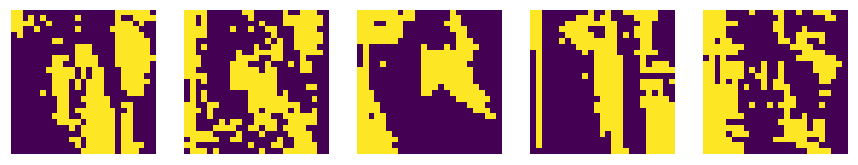

None


Iteration i= 3800 learning rate 0.037425742574257424 , train accuracy= 0.74862 , f1= 0.585575081203 , loss= 26380.8
0.0251091
0.0720341
0.0224039
0.0750148
0.0241253
0.0621174
0.0218033
0.0673798
0.0157883
0.128566


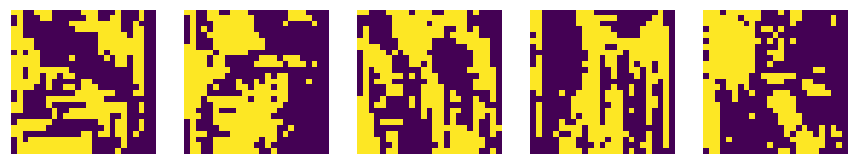

None


Iteration i= 3900 learning rate 0.03683168316831683 , train accuracy= 0.754861 , f1= 0.587449818596 , loss= 25597.3
0.0151706
0.141922
0.0223134
0.0810277
0.0205666
0.107616
0.0183572
0.0798402
0.0104628
0.112943


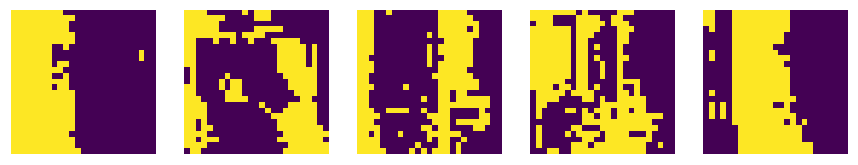

None


Iteration i= 4000 learning rate 0.036237623762376235 , train accuracy= 0.749881 , f1= 0.573894282632 , loss= 26226.1
0.0308406
0.0631698
0.0220003
0.0870481
0.0224895
0.0818867
0.0127772
0.0942351
0.0205233
0.0911817


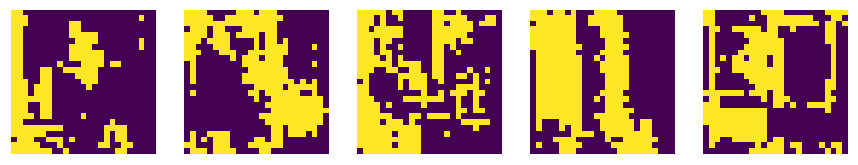

None


Iteration i= 4100 learning rate 0.03564356435643564 , train accuracy= 0.743575 , f1= 0.565590007715 , loss= 27007.0
0.018187
0.0787488
0.0177082
0.107157
0.0230077
0.0722378
0.0230775
0.0768906
0.0207374
0.074539


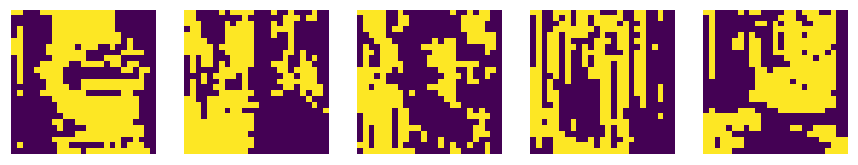

None


Iteration i= 4200 learning rate 0.03504950495049505 , train accuracy= 0.786133 , f1= 0.58024691358 , loss= 21688.8
0.0181189
0.105116
0.0245212
0.070948
0.019098
0.0979121
0.0235093
0.0907004
0.0217919
0.0793665


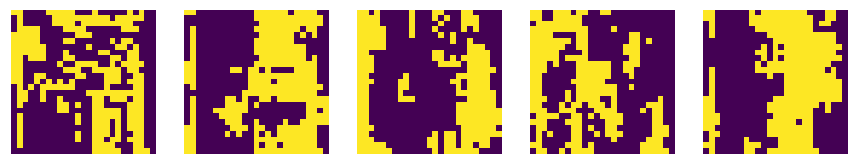

None


Iteration i= 4300 learning rate 0.03445544554455446 , train accuracy= 0.762219 , f1= 0.576208261579 , loss= 24660.1
0.0182545
0.0801328
0.0179704
0.103156
0.0206941
0.115948
0.0282086
0.0735307
0.0285026
0.0757364


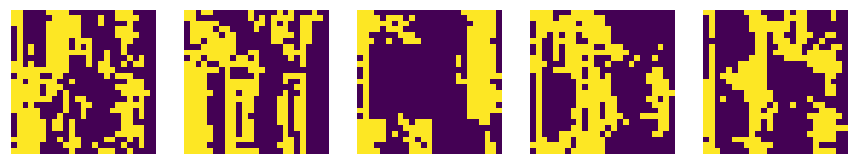

None


Iteration i= 4400 learning rate 0.033861386138613864 , train accuracy= 0.744222 , f1= 0.594223562001 , loss= 26917.5
0.023702
0.0880124
0.0237132
0.089577
0.0227255
0.0750345
0.0211448
0.0842268
0.0189517
0.116416


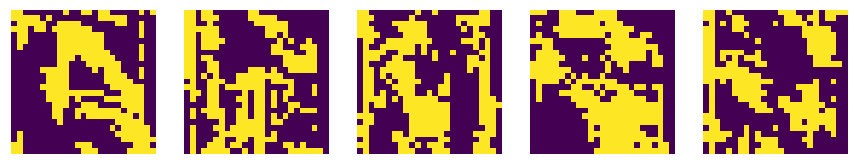

None


Iteration i= 4500 learning rate 0.03326732673267327 , train accuracy= 0.74873 , f1= 0.555646728568 , loss= 26351.4
0.0205202
0.183551
0.0213765
0.111559
0.0272657
0.0827036
0.0199446
0.115823
0.0272435
0.0651482


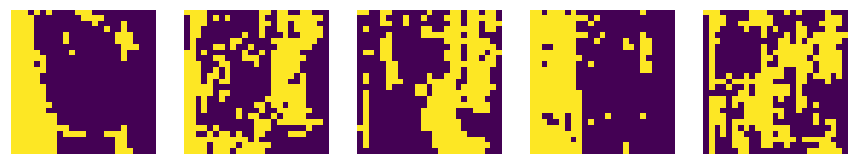

None


Iteration i= 4600 learning rate 0.032673267326732675 , train accuracy= 0.737076 , f1= 0.563418650511 , loss= 27837.9
0.0186104
0.080171
0.0195784
0.108231
0.0237667
0.102189
0.0135115
0.140097
0.0211088
0.0991992


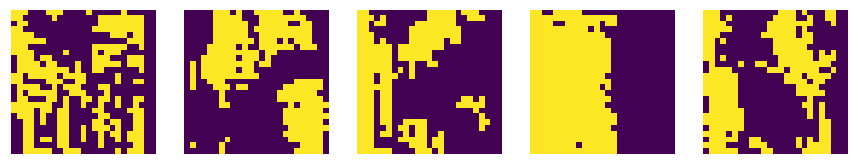

None


Iteration i= 4700 learning rate 0.03207920792079208 , train accuracy= 0.737676 , f1= 0.573462888208 , loss= 27751.0
0.0240413
0.0895988
0.0221057
0.0790403
0.0205758
0.0758665
0.0244718
0.085497
0.0199446
0.115823


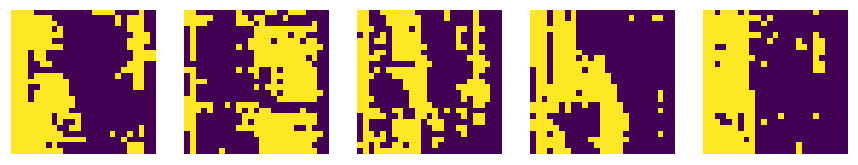

None


Iteration i= 4800 learning rate 0.031485148514851485 , train accuracy= 0.770637 , f1= 0.592686409064 , loss= 23647.6
0.0202666
0.0705319
0.0222351
0.0687103
0.0213628
0.102201
0.020344
0.116137
0.0251127
0.0699143


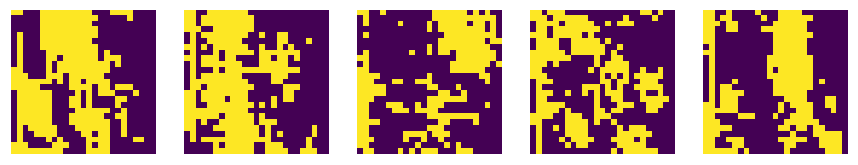

None


Iteration i= 4900 learning rate 0.03089108910891089 , train accuracy= 0.748158 , f1= 0.572557181388 , loss= 26429.7
0.0279361
0.0592715
0.0229385
0.0640564
0.0209371
0.150981
0.017792
0.104347
0.0234142
0.103907


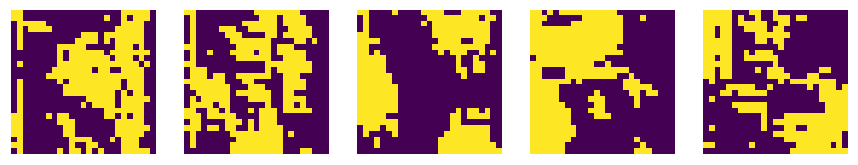

None


Iteration i= 5000 learning rate 0.030297029702970296 , train accuracy= 0.768886 , f1= 0.581491073906 , loss= 23847.9
0.0182118
0.0985389
0.0228943
0.0938627
0.0226341
0.0652093
0.0250805
0.0808935
0.024617
0.0716138


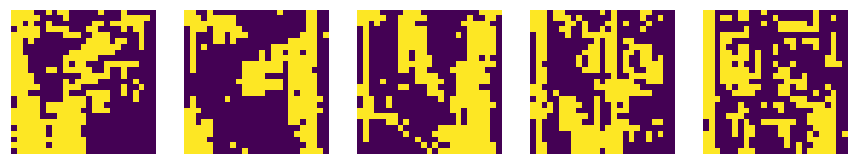

None


Iteration i= 5100 learning rate 0.0297029702970297 , train accuracy= 0.727099 , f1= 0.572226207324 , loss= 29056.5
0.0230298
0.0935673
0.0198737
0.0853493
0.0274193
0.0811859
0.0253351
0.108331
0.0218382
0.137534


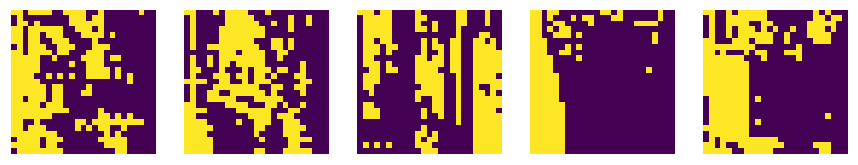

None


Iteration i= 5200 learning rate 0.029108910891089107 , train accuracy= 0.744461 , f1= 0.569375025817 , loss= 26895.4
0.0256708
0.065307
0.0229781
0.0697035
0.018717
0.0939355
0.0208585
0.108765
0.0176499
0.0838493


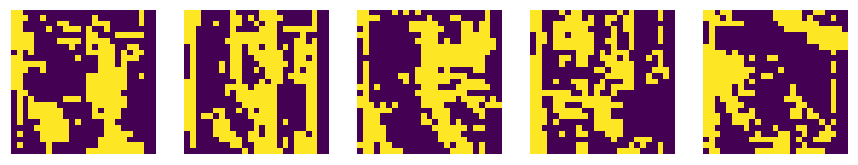

None


Iteration i= 5300 learning rate 0.028514851485148512 , train accuracy= 0.750914 , f1= 0.555613531611 , loss= 26086.2
0.0151511
0.0916718
0.0217689
0.0758113
0.0242174
0.110278
0.0183103
0.117669
0.0234416
0.0838614


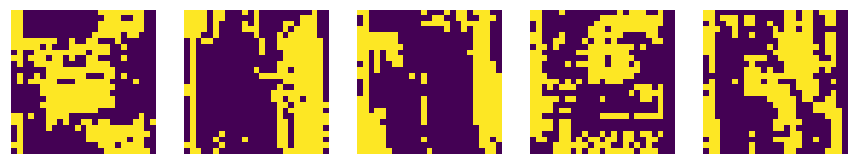

None


Iteration i= 5400 learning rate 0.027920792079207918 , train accuracy= 0.784166 , f1= 0.561710990881 , loss= 21931.6
0.0230397
0.0700236
0.0235463
0.0887614
0.0187172
0.137806
0.0273223
0.0753851
0.02522
0.0737937


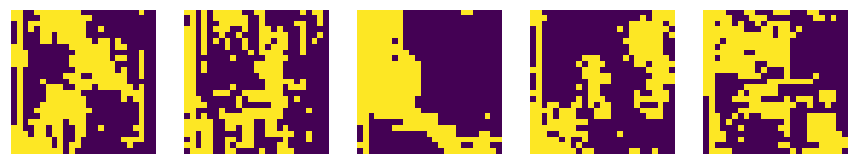

None


Iteration i= 5500 learning rate 0.027326732673267323 , train accuracy= 0.763005 , f1= 0.587648999933 , loss= 24596.6
0.0197222
0.121205
0.0157868
0.0833964
0.0208036
0.0884287
0.0281882
0.0810584
0.0200731
0.130803


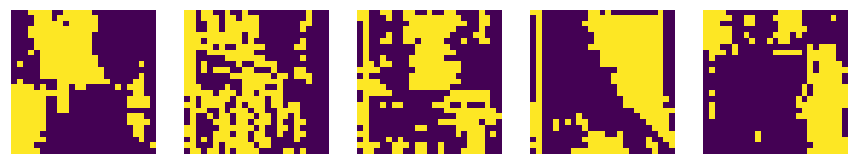

None


Iteration i= 5600 learning rate 0.02673267326732673 , train accuracy= 0.758983 , f1= 0.581022093882 , loss= 25108.5
0.0261634
0.0741993
0.0263297
0.0753901
0.0207374
0.074539
0.0221953
0.0878801
0.019652
0.0903271


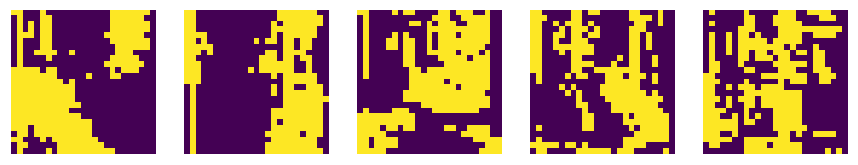

None


Iteration i= 5700 learning rate 0.02613861386138614 , train accuracy= 0.746622 , f1= 0.574905897114 , loss= 26624.9
0.021668
0.0699344
0.0242481
0.0638277
0.0217811
0.0898811
0.0219763
0.0681603
0.0234187
0.0673952


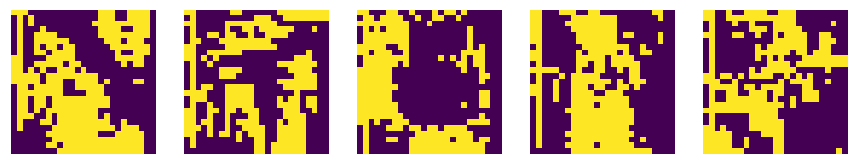

None


Iteration i= 5800 learning rate 0.025544554455445546 , train accuracy= 0.766068 , f1= 0.559394844976 , loss= 24208.4
0.0237354
0.0709714
0.0203773
0.102497
0.0254711
0.0663346
0.0199098
0.0786043
0.015944
0.104222


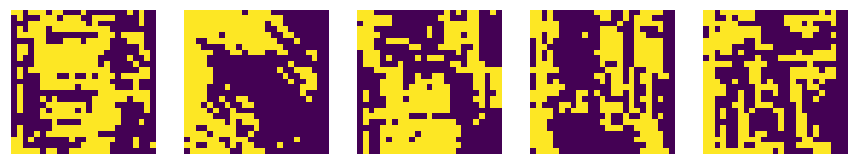

None


Iteration i= 5900 learning rate 0.024950495049504952 , train accuracy= 0.752976 , f1= 0.581440818168 , loss= 25840.5
0.0305219
0.068361
0.0198633
0.0845157
0.0152919
0.113934
0.0128742
0.117301
0.0231982
0.0724438


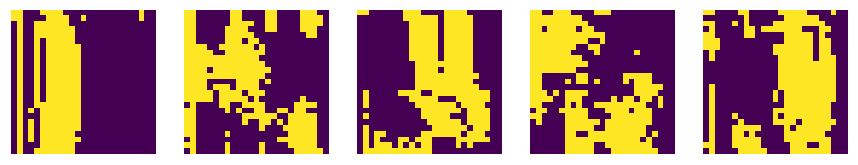

None


Iteration i= 6000 learning rate 0.024356435643564357 , train accuracy= 0.763649 , f1= 0.572040365384 , loss= 24525.4
0.0222822
0.0671615
0.0252086
0.0757889
0.0247613
0.105631
0.0230929
0.115094
0.0199979
0.128128


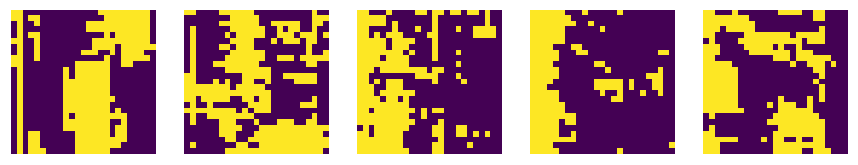

None


Iteration i= 6100 learning rate 0.023762376237623763 , train accuracy= 0.743311 , f1= 0.564497609653 , loss= 27028.9
0.0176463
0.0960574
0.0177082
0.107157
0.0238898
0.0905363
0.0225581
0.0834516
0.02329
0.110228


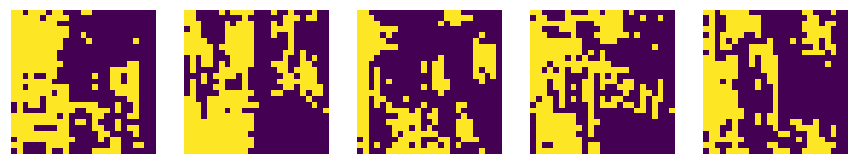

None


Iteration i= 6200 learning rate 0.023168316831683168 , train accuracy= 0.746375 , f1= 0.582019617235 , loss= 26631.9
0.0262186
0.0712625
0.0218984
0.0802381
0.0272657
0.0827036
0.0226728
0.0967484
0.0194523
0.0786241


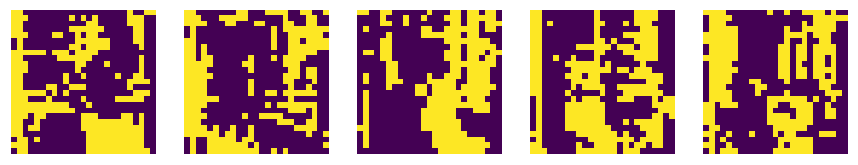

None


Iteration i= 6300 learning rate 0.022574257425742573 , train accuracy= 0.755586 , f1= 0.563621026461 , loss= 25501.8
0.01748
0.182843
0.0230775
0.0768906
0.0221535
0.0856376
0.0213611
0.096302
0.0208482
0.108993


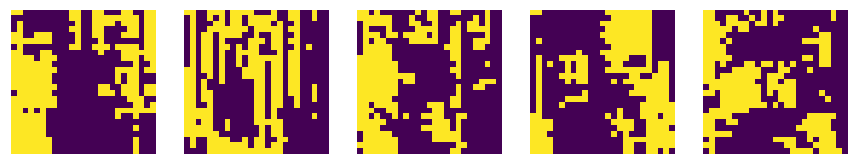

None


Iteration i= 6400 learning rate 0.02198019801980198 , train accuracy= 0.757329 , f1= 0.569793392995 , loss= 25281.2
0.0205233
0.0911817
0.0232848
0.0951262
0.0125709
0.0909836
0.0255004
0.101581
0.020222
0.0724774


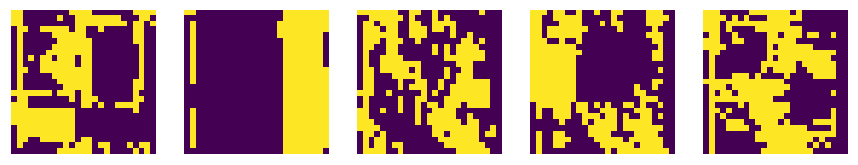

None


Iteration i= 6500 learning rate 0.021386138613861384 , train accuracy= 0.738217 , f1= 0.568688156377 , loss= 27659.0
0.0178019
0.144069
0.025152
0.0721234
0.0232129
0.0701428
0.0203542
0.0863784
0.0177474
0.0760955


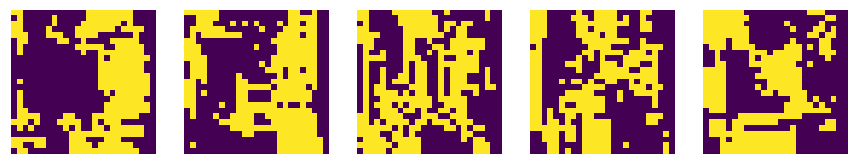

None


Iteration i= 6600 learning rate 0.02079207920792079 , train accuracy= 0.746262 , f1= 0.580250751217 , loss= 26654.7
0.0199679
0.0721273
0.0226622
0.0795324
0.025369
0.067039
0.023625
0.0912667
0.0231358
0.0747792


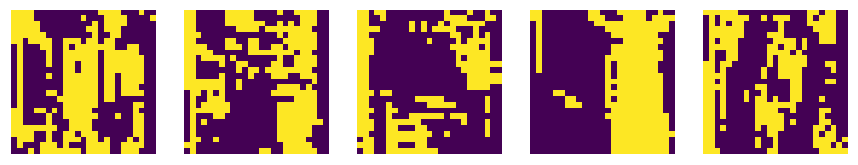

None


Iteration i= 6700 learning rate 0.020198019801980195 , train accuracy= 0.772224 , f1= 0.566617207188 , loss= 23436.8
0.0183054
0.0963299
0.0190545
0.102774
0.0157868
0.0833964
0.0221354
0.0630033
0.0219118
0.0750485


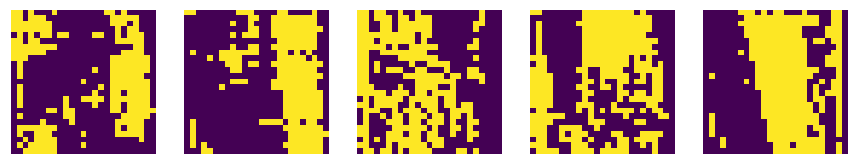

None


Iteration i= 6800 learning rate 0.0196039603960396 , train accuracy= 0.76189 , f1= 0.552608755192 , loss= 24715.6
0.0209084
0.0973755
0.0180536
0.0979612
0.0258567
0.0726406
0.0134653
0.109541
0.0233425
0.0836517


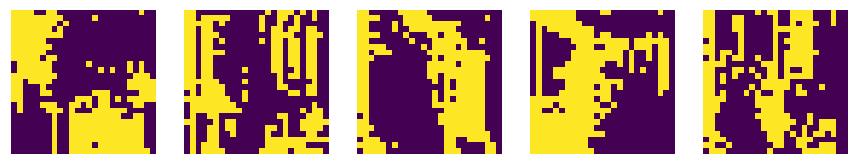

None


Iteration i= 6900 learning rate 0.019009900990099006 , train accuracy= 0.738276 , f1= 0.569015236732 , loss= 27665.4
0.0216055
0.102847
0.0237111
0.0652531
0.0233425
0.0836517
0.0276732
0.0878181
0.0244884
0.0772311


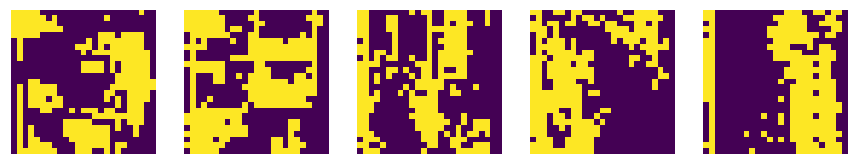

None


Iteration i= 7000 learning rate 0.01841584158415842 , train accuracy= 0.740435 , f1= 0.555530263839 , loss= 27395.4
0.0217954
0.0888362
0.020587
0.0875787
0.0301396
0.070961
0.0214506
0.111925
0.0219053
0.0843848


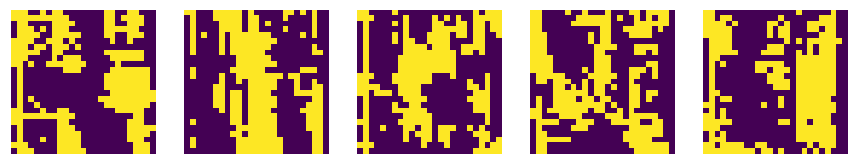

None


Iteration i= 7100 learning rate 0.017821782178217824 , train accuracy= 0.749979 , f1= 0.578951842564 , loss= 26201.0
0.0267731
0.0787122
0.0252513
0.0822184
0.0263227
0.108773
0.018717
0.0939355
0.0153157
0.235611


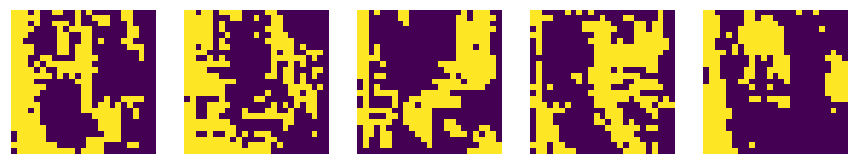

None


Iteration i= 7200 learning rate 0.01722772277227723 , train accuracy= 0.749337 , f1= 0.567462782478 , loss= 26294.0
0.0233203
0.146323
0.0242189
0.0671214
0.0224163
0.0671995
0.0126076
0.105727
0.0230445
0.0789711


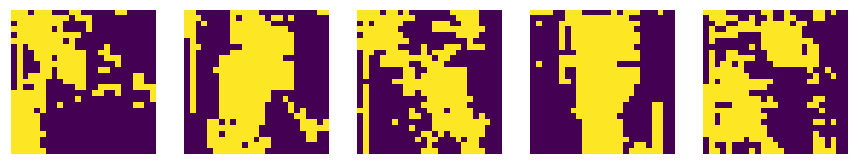

None


Iteration i= 7300 learning rate 0.016633663366336635 , train accuracy= 0.778034 , f1= 0.56758269844 , loss= 22705.8
0.0207096
0.116934
0.0210356
0.0841207
0.0180485
0.144423
0.0254397
0.0632642
0.0217963
0.0703786


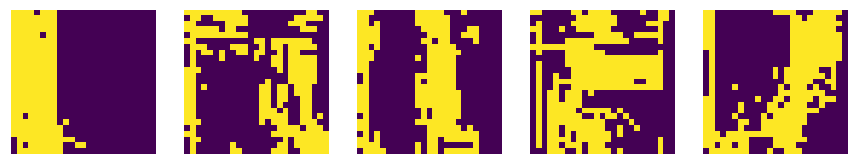

None


Iteration i= 7400 learning rate 0.01603960396039604 , train accuracy= 0.742927 , f1= 0.589629750316 , loss= 27053.5
0.0204833
0.0659563
0.02329
0.110228
0.0282086
0.0735307
0.0238175
0.100008
0.0197481
0.0699713


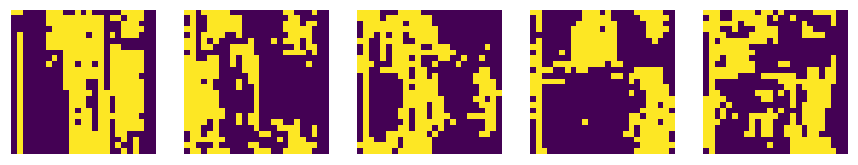

None


Iteration i= 7500 learning rate 0.015445544554455445 , train accuracy= 0.761024 , f1= 0.596078605726 , loss= 24840.4
0.0219763
0.0681603
0.0257235
0.0706304
0.0205948
0.0962349
0.0203986
0.0916897
0.0258138
0.0745564


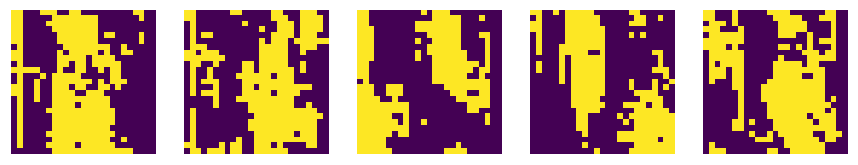

None


Iteration i= 7600 learning rate 0.01485148514851485 , train accuracy= 0.775772 , f1= 0.570379141193 , loss= 23015.4
0.0255004
0.101581
0.0182969
0.148928
0.0255024
0.076589
0.0239288
0.0836943
0.0144975
0.0771705


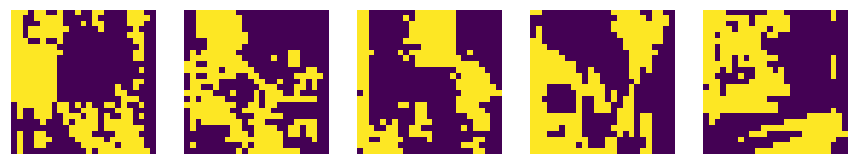

None


Iteration i= 7700 learning rate 0.014257425742574256 , train accuracy= 0.766178 , f1= 0.563804023845 , loss= 24210.5
0.0209231
0.118462
0.0225058
0.0915997
0.02664
0.0870767
0.0292993
0.0727998
0.0167893
0.0705552


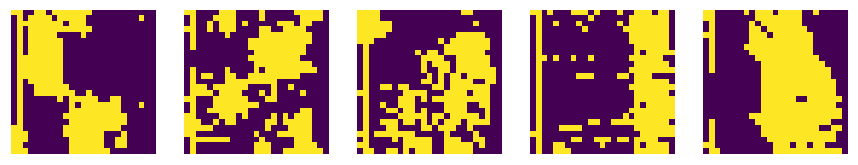

None


Iteration i= 7800 learning rate 0.013663366336633662 , train accuracy= 0.758029 , f1= 0.583021936959 , loss= 25203.2
0.0215452
0.0801231
0.0231567
0.093329
0.0277791
0.0630127
0.0155213
0.105128
0.0236943
0.0858864


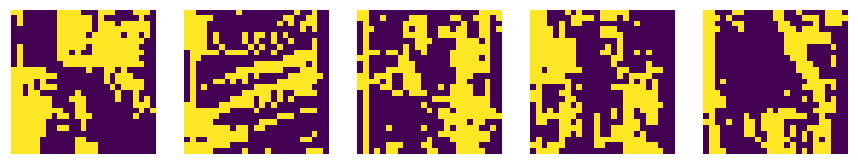

None


Iteration i= 7900 learning rate 0.013069306930693067 , train accuracy= 0.740584 , f1= 0.580775118846 , loss= 27361.4
0.0251584
0.0962774
0.0233636
0.0789092
0.0228874
0.089257
0.0174754
0.0959332
0.0179704
0.103156


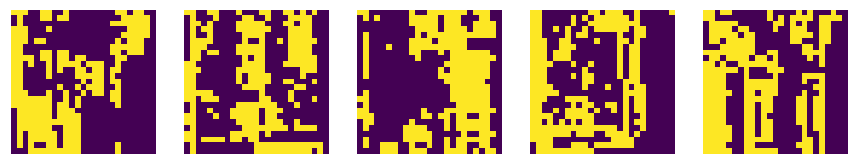

None


Iteration i= 8000 learning rate 0.012475247524752472 , train accuracy= 0.757487 , f1= 0.56566190728 , loss= 25258.2
0.0237673
0.0705662
0.0120583
0.256947
0.0171268
0.123652
0.0242021
0.0804962
0.0231176
0.0663689


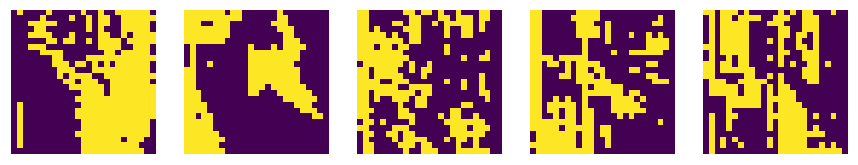

None


Iteration i= 8100 learning rate 0.011881188118811878 , train accuracy= 0.775879 , f1= 0.571105551814 , loss= 22994.5
0.0233447
0.0713352
0.0170753
0.125096
0.0248872
0.0712368
0.0174692
0.0879366
0.025929
0.0641571


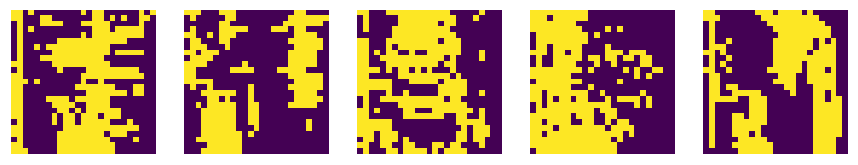

None


Iteration i= 8200 learning rate 0.011287128712871283 , train accuracy= 0.750364 , f1= 0.575489133898 , loss= 26152.8
0.0238593
0.0787231
0.0126607
0.0999072
0.0234026
0.0915986
0.010497
0.123134
0.0199629
0.097948


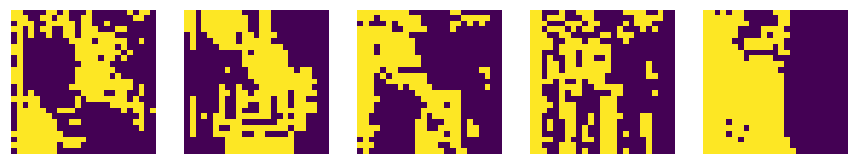

None


Iteration i= 8300 learning rate 0.010693069306930696 , train accuracy= 0.755509 , f1= 0.566278764546 , loss= 25519.9
0.0240993
0.105558
0.0214805
0.0850689
0.022861
0.0653062
0.0218052
0.0655797
0.0123421
0.113851


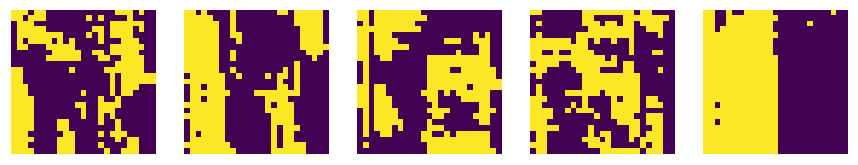

None


Iteration i= 8400 learning rate 0.010099009900990101 , train accuracy= 0.752512 , f1= 0.581678411275 , loss= 25906.8
0.0205955
0.122453
0.0293792
0.0971124
0.0188493
0.195812
0.0121285
0.11166
0.021994
0.0673102


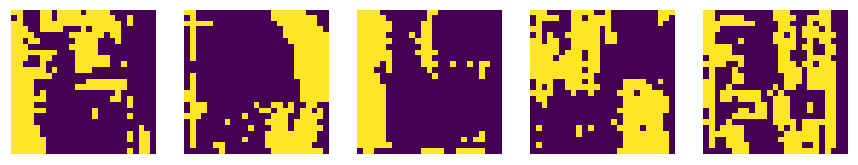

None


Iteration i= 8500 learning rate 0.009504950495049506 , train accuracy= 0.746634 , f1= 0.555857154975 , loss= 26609.7
0.0170753
0.125096
0.0195047
0.110165
0.0260076
0.0837354
0.0258152
0.0733209
0.0235861
0.122533


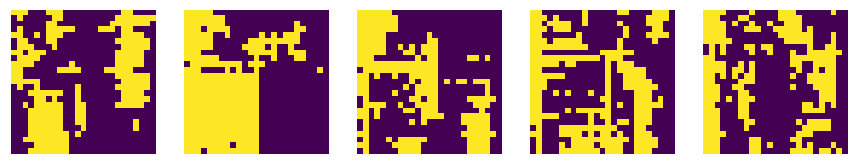

None


Iteration i= 8600 learning rate 0.008910891089108912 , train accuracy= 0.764049 , f1= 0.570341516442 , loss= 24453.7
0.0178993
0.11613
0.0235861
0.122533
0.021673
0.0816688
0.0191132
0.112604
0.0266393
0.0602708


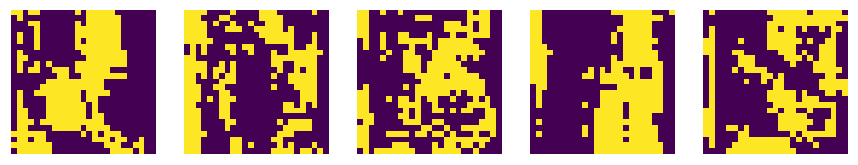

None


Iteration i= 8700 learning rate 0.008316831683168317 , train accuracy= 0.773505 , f1= 0.578919819177 , loss= 23295.5
0.0236169
0.0658424
0.0275742
0.0714799
0.0190545
0.102774
0.0163572
0.105775
0.0208204
0.0870208


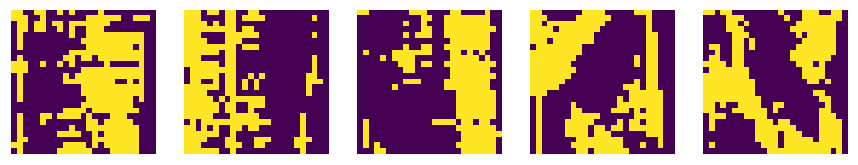

None


Iteration i= 8800 learning rate 0.007722772277227723 , train accuracy= 0.752487 , f1= 0.588280206146 , loss= 25889.1
0.0186855
0.090941
0.012083
0.0837831
0.0240861
0.0716393
0.0197557
0.107007
0.0221354
0.0630033


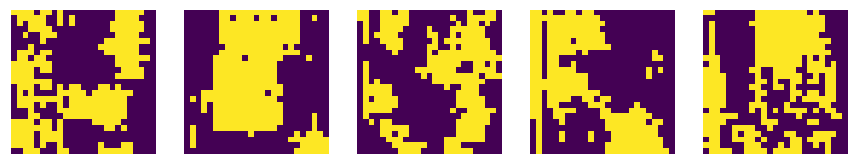

None


Iteration i= 8900 learning rate 0.007128712871287128 , train accuracy= 0.758683 , f1= 0.579272838911 , loss= 25118.7
0.0197481
0.0699713
0.00976843
0.130565
0.0212964
0.108878
0.022284
0.0629418
0.0240956
0.0697907


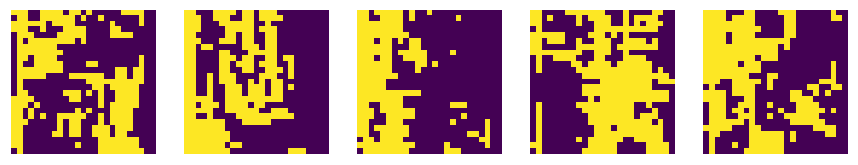

None


Iteration i= 9000 learning rate 0.0065346534653465335 , train accuracy= 0.75572 , f1= 0.564293258229 , loss= 25509.0
0.0187416
0.127783
0.0209371
0.150981
0.030232
0.0604139
0.0175082
0.116011
0.0256218
0.0938094


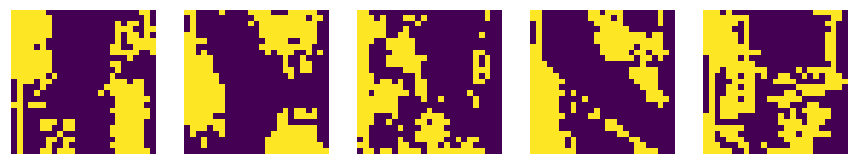

None


Iteration i= 9100 learning rate 0.005940594059405939 , train accuracy= 0.738241 , f1= 0.575731811004 , loss= 27659.2
0.0173697
0.099571
0.0186707
0.107343
0.0166757
0.102024
0.025373
0.0780004
0.0207463
0.135565


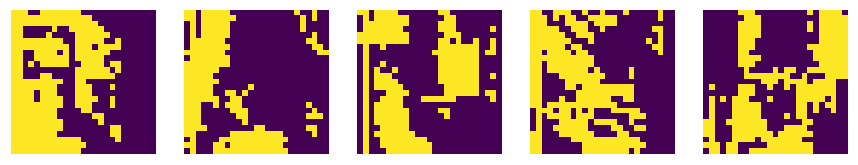

None


Iteration i= 9200 learning rate 0.005346534653465344 , train accuracy= 0.759668 , f1= 0.567856177345 , loss= 24999.8
0.0284519
0.0618372
0.0171558
0.0854527
0.0184135
0.144902
0.0232961
0.0688006
0.0220003
0.0870481


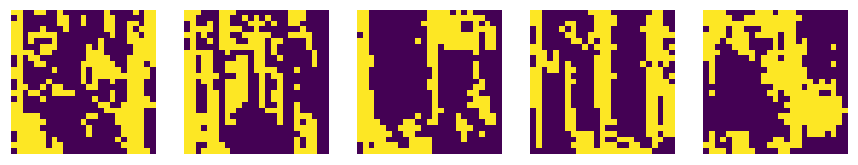

None


Iteration i= 9300 learning rate 0.00475247524752475 , train accuracy= 0.757176 , f1= 0.575090356771 , loss= 25344.5
0.0253447
0.0755093
0.021907
0.0859152
0.0309291
0.0664845
0.024625
0.0948742
0.0250445
0.105775


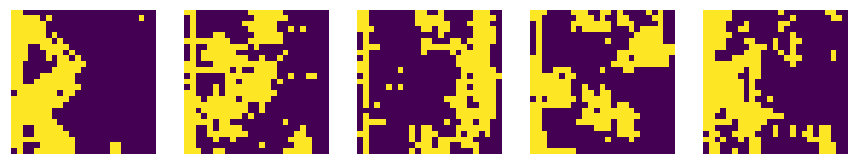

None


Iteration i= 9400 learning rate 0.004158415841584155 , train accuracy= 0.740331 , f1= 0.567135418802 , loss= 27412.0
0.02288
0.0893206
0.0131953
0.157411
0.012083
0.0837831
0.0178993
0.11613
0.0218188
0.111837


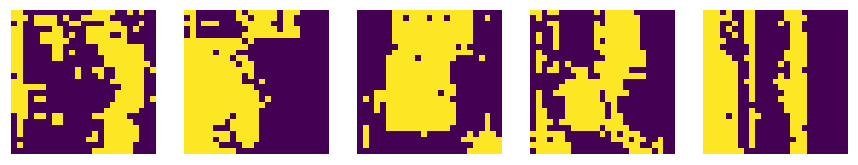

None


Iteration i= 9500 learning rate 0.0035643564356435675 , train accuracy= 0.736132 , f1= 0.568937875752 , loss= 27912.8
0.025969
0.0774601
0.0268527
0.0669696
0.0279587
0.0741843
0.0214495
0.111046
0.0186035
0.0862347


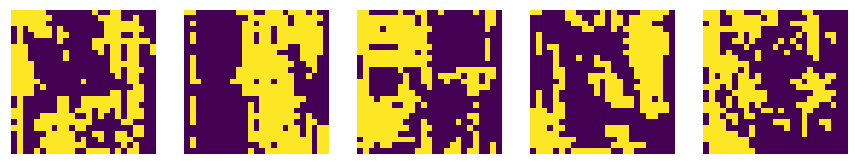

None


Iteration i= 9600 learning rate 0.002970297029702973 , train accuracy= 0.752003 , f1= 0.580641020155 , loss= 25972.7
0.0272709
0.0948172
0.0237354
0.0709714
0.0152945
0.0961632
0.0232864
0.0684457
0.0211612
0.092472


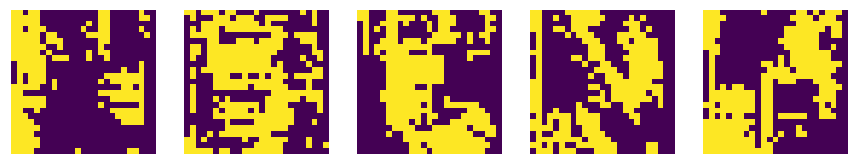

None


Iteration i= 9700 learning rate 0.0023762376237623783 , train accuracy= 0.757135 , f1= 0.569415738827 , loss= 25296.8
0.0219749
0.0781513
0.0210676
0.0793052
0.0208204
0.0870208
0.0180982
0.0860897
0.0171702
0.106852


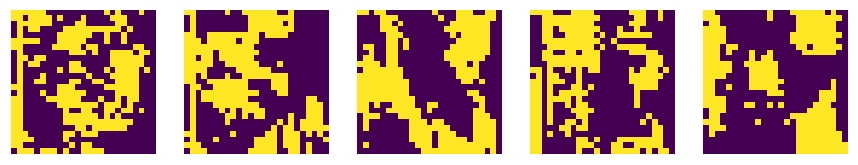

None


Iteration i= 9800 learning rate 0.0017821782178217838 , train accuracy= 0.759228 , f1= 0.565062146893 , loss= 25053.3
0.0267523
0.0695468
0.0175881
0.0832809
0.0201669
0.107161
0.0256061
0.110598
0.0158549
0.0776612


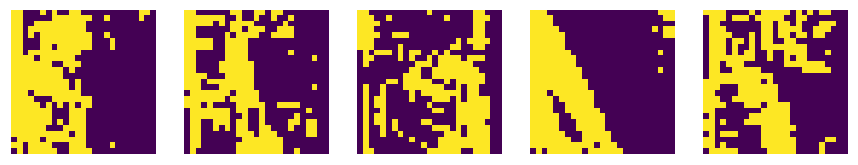

None


Iteration i= 9900 learning rate 0.0011881188118811892 , train accuracy= 0.725787 , f1= 0.563406952254 , loss= 29204.7
0.02296
0.0878482
0.0158359
0.0989705
0.0193768
0.112425
0.0230395
0.0654647
0.0204804
0.0782081


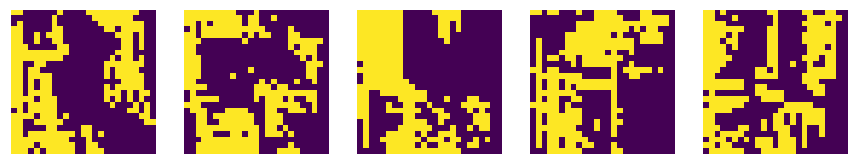

None


Iteration i= 10000 learning rate 0.0005940594059405946 , train accuracy= 0.75829 , f1= 0.579693503511 , loss= 25151.2
0.0234187
0.0673952
0.0178019
0.144069
0.0215982
0.0898386
0.0232588
0.0849965
0.0229083
0.0764317


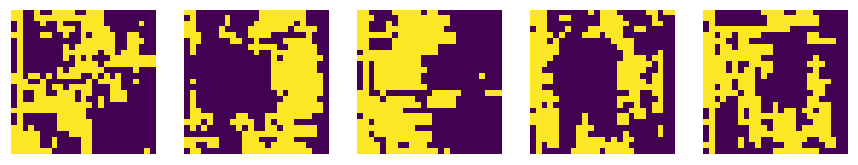

None

In [8]:
# Run Computational Graph
indices = collections.deque()
#init = tf.global_variables_initializer()
#sess = tf.Session()
print('Initializing computational Graph')
#sess.run(init)
print('Finished computational Graph. Starting training.')

for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x = train_data[idx,:,:]
    batch_y = train_labels[idx,:]
    
    # Run CG for vao to increase the test acriable training
    acc_train,total_loss_o,y_o ,y_t = sess.run([accuracy,total_loss, y, y_truth_maxpooled], feed_dict={xin_3cols: batch_x, y_truth: batch_y, learn_rate:0.06*(1-(i/10100))})
    
    # Run CG for test set
    if not i%100:
        plt.rcParams['figure.figsize'] = (15.0, 15.0)
        print('\nIteration i=',i,'learning rate',0.06*(1-(i/10100)),', train accuracy=',acc_train,', f1=',calc_f1_score(y_o,y_t),', loss=',total_loss_o)
        for i in range(5):
            sample_mask = np.reshape(y_o,[200,25,25])[i,:,:]
            print(np.min(sample_mask))
            print(np.max(sample_mask))
            sample_mask[sample_mask>np.mean(sample_mask)] = 1.0
            sample_mask[sample_mask<np.mean(sample_mask)] = 0.0

            
            plt.subplot(1,5,i+1)
            plt.axis('off')
            plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
            plt.imshow(sample_mask)
        display(plt.show())
 